In [1]:
import torch
import torchaudio
import PIL.Image
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop
from IPython.display import Audio as play
from datasets import load_dataset, Audio
from tft.mdct import mdct, inverse_mdct, mdct2d, inverse_mdct2d
from tft.utils import compand, decompand

In [2]:
esc50 = load_dataset("danjacobellis/esc_50",split='train').cast_column('opus', Audio(decode=False))
x, fs = torchaudio.load(esc50[33]['opus']['bytes'],normalize=False);
assert fs==48000; assert x.min() >= -1.0; assert x.max() <= 1.0
n_frames = 448
n_freq = 512
x = x[0,:((n_frames+1)*n_freq)]
assert x.shape[0] == ((n_frames+1)*n_freq)
play(x,rate=48000)

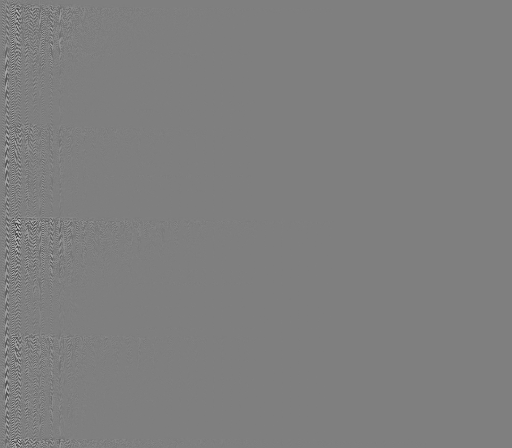

In [3]:
X = compand(mdct(
    signals = x,
    frame_length = 2*n_freq,
))/10
X = CenterCrop((X.shape[0]+32,X.shape[1]+32))(X)
ξ = compand(mdct2d(X, 64, 64))/10
ξ2 = (255*ξ).round().clamp(-127,127)/255
X_hat = inverse_mdct2d(decompand(ξ2*10))
X_hat = CenterCrop((X.shape[0]-32,X.shape[1]-32))(X_hat)
display(ToPILImage()(X_hat/2 + 0.5))
x_hat_hat = inverse_mdct(
    mdcts = decompand(10*X_hat),
)
display(play(x_hat_hat,rate=fs))

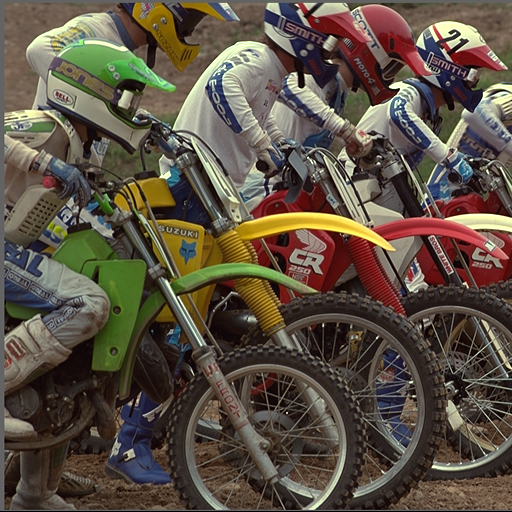

In [4]:
img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
Y = compand(mdct2d(y, 64, 64))/40
Y2 = (255*Y).round().clamp(-127,127)/255
y_hat = inverse_mdct2d(decompand(40*Y2))
y_hat = CenterCrop((y.shape[1]-32, y.shape[2]-32))(y)
ToPILImage()((y_hat/2).clamp(-0.5,0.5)+0.5)